In [1]:
import tensorflow as tf
import os

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model

In [3]:
!unzip '/content/archive (5).zip'

Streaming output truncated to the last 5000 lines.
  inflating: training_set/training_set/cats/cat.3704.jpg  
  inflating: training_set/training_set/cats/cat.3705.jpg  
  inflating: training_set/training_set/cats/cat.3706.jpg  
  inflating: training_set/training_set/cats/cat.3707.jpg  
  inflating: training_set/training_set/cats/cat.3708.jpg  
  inflating: training_set/training_set/cats/cat.3709.jpg  
  inflating: training_set/training_set/cats/cat.371.jpg  
  inflating: training_set/training_set/cats/cat.3710.jpg  
  inflating: training_set/training_set/cats/cat.3711.jpg  
  inflating: training_set/training_set/cats/cat.3712.jpg  
  inflating: training_set/training_set/cats/cat.3713.jpg  
  inflating: training_set/training_set/cats/cat.3714.jpg  
  inflating: training_set/training_set/cats/cat.3715.jpg  
  inflating: training_set/training_set/cats/cat.3716.jpg  
  inflating: training_set/training_set/cats/cat.3717.jpg  
  inflating: training_set/training_set/cats/cat.3718.jpg  
  infl

In [5]:
# Define image size and batch size
image_size=224
batch_size=128
train_data='/content/training_set/training_set'

# creating imagedagenerator  with data augmentation
train_datagen = ImageDataGenerator(
        rescale=1./255,      # Normalize pixel values
        zoom_range=0.2, # Apply random zoom
        horizontal_flip=True,   # Randomly flip images horizontally
        validation_split=0.2) # Apply validation split

# Loading training data
train_generator = train_datagen.flow_from_directory(
        train_data,  # Path to training data
        target_size=(image_size, image_size),  # Resize images to 224x224
        batch_size=batch_size,   # Load data in batches
        class_mode='categorical',  # One-hot encoding for labels
        classes=['cats', 'dogs'] )  # Specify the two classes




Found 8005 images belonging to 2 classes.


In [6]:
test_data='/content/test_set/test_set'

# creating imagedagenerator  without data augmentation
test_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2)


# Load testing data
test_generator = test_datagen.flow_from_directory(
        test_data,
        target_size=(image_size, image_size),
        batch_size=batch_size,
        class_mode='categorical',
        classes=['cats', 'dogs'] )

Found 2023 images belonging to 2 classes.


In [7]:
class_indices = train_generator.class_indices

# Display the class indices
print("Class indices (number allotted to each class):")
for class_name, index in class_indices.items():
    print(f"{class_name}: {index}")

Class indices (number allotted to each class):
cats: 0
dogs: 1


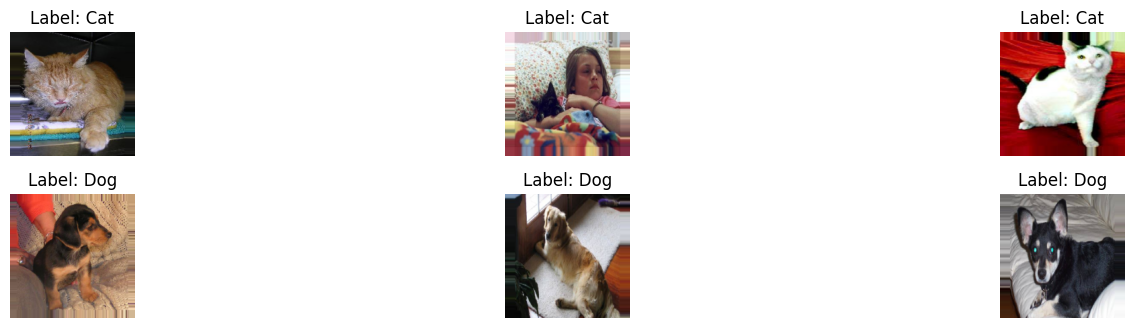

In [8]:
# Function to plot images
def plot_images(generator, num_images=6):
    # Get a batch of images and labels from the generator
    images, labels = next(generator)  # Retrieve the next batch

    # Set up the plot
    plt.figure(figsize=(15, 5))

    for i in range(num_images):
        plt.subplot(3, 3, i + 1)  # Create a 3x3 grid of subplots
        plt.imshow(images[i])      # Display the image
        plt.axis('off')            # Hide the axis

       # Determine the label based on the binary classification
        label = 'Dog' if labels[i][1] == 1 else 'Cat'
        plt.title(f'Label: {label}', fontsize=12)

    plt.tight_layout()
    plt.show()

plot_images(train_generator, num_images=6)


In [9]:
# Load the VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(image_size,image_size,3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [10]:
# Freeze the convolutional layers of VGG16 to keep the pre-trained weights
for layer in base_model.layers:
    layer.trainable = False

In [11]:
# Add new fully connected layers on top of the base model
x = base_model.output
x = Flatten()(x) # Add Fatten layer
x = Dense(1024, activation='relu')(x)  # Add a dense layer with 1024 units and ReLU activation

In [12]:
predictions = Dense(2, activation='softmax')(x)  # Output layer with softmax activation

In [13]:
# Create the new model combining VGG16 and the new layers
model = Model(inputs=base_model.input, outputs=predictions)

In [14]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │      25,691,136 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 40,407,874 (154.14 MB)

 Trainable params: 25,693,186 (98.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [15]:
model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])

In [16]:
history=model.fit(train_generator,epochs=1,
                  batch_size= 64, validation_data=test_generator)

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


63/63 ━━━━━━━━━━━━━━━━━━━━ 5548s 88s/step - accuracy: 0.7020 - loss: 2.7048 - val_accuracy: 0.9086 - val_loss: 0.2205


In [27]:
model.save('my_model.h5')

4/4 ━━━━━━━━━━━━━━━━━━━━ 77s 20s/step


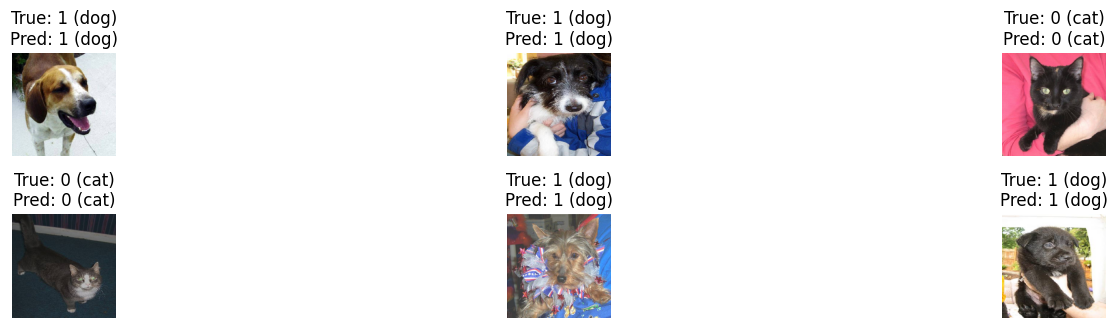

In [30]:
# Function to plot images along with their predictions
def plot_predictions(generator, model, num_images=6):
    # Define the label mapping
    label_map = {0: 'cat', 1: 'dog'}

    # Get a batch of images and labels from the generator
    images, labels = next(generator)

    # Generate predictions
    predictions = model.predict(images)

    # output layer is using softmax there we are setting it on np.argmax()
    predicted_classes = np.argmax(predictions, axis=1)

    # If labels are one-hot encoded, convert them back to class indices
    if labels.shape[1] > 1:
        true_labels = np.argmax(labels, axis=1)
    else:
        true_labels = labels

    # Set up the plot
    plt.figure(figsize=(15, 5))

    for i in range(num_images):
        plt.subplot(3, 3, i + 1)  # Create a 3x3 grid of subplots
        plt.imshow(images[i])  # Display the image
        plt.axis('off')  # Hide the axis

        # Determine the true and predicted labels
        true_label = int(true_labels[i])
        predicted_label = int(predicted_classes[i])

        # Display true and predicted labels with both 0/1 and text ("cat" or "dog")
        plt.title(f'True: {true_label} ({label_map[true_label]})\nPred: {predicted_label} ({label_map[predicted_label]})', fontsize=12)

    plt.tight_layout()
    plt.show()

plot_predictions(test_generator, model, num_images=6)
